In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [62]:
data = pd.read_csv('SPY.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,26.079659,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,26.265144,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.320782,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.599014,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.710312,531500
...,...,...,...,...,...,...,...
7010,2020-11-30,362.829987,363.119995,359.170013,362.059998,362.059998,83872700
7011,2020-12-01,365.570007,367.679993,364.929993,366.019989,366.019989,74505000
7012,2020-12-02,364.820007,366.959991,364.200012,366.790009,366.790009,45927000
7013,2020-12-03,366.679993,368.190002,365.500000,366.690002,366.690002,62882000


<h1> Min Max Normalization </h1>

In [52]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data[data.columns[1:]])

<h1> Dimensionality Reduction </h1>

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(training_set_scaled)

PCA(n_components=1)

In [66]:
reduced_data = pca.transform(training_set_scaled)
pickle.dump(pca, open('pca-model' ,'wb'))

<h1> Train Test Split </h1>

In [55]:
def input_label_splitter(window_size, input_data):
    n = len(input_data)    
    train_inputs = []
    train_labels = []
    for i in range(61, n-1):
        train_inputs.append(input_data[i-window_size:i])
        train_labels.append(input_data[i])
    return np.array(train_inputs), np.array(train_labels)

In [56]:
from sklearn.model_selection import train_test_split
X, y = input_label_splitter(20, reduced_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False, random_state = False)

<h1> Stacked LSTMS fed on data with reduced dimension </h1>

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow

In [114]:

class LSTM_Model(keras.Model):    
    def __init__(self, optimizer, inp_shape):
        super(LSTM_Model, self).__init__()
                
        self.optimizer = optimizer

        #1st Convolution Layer
        self.LSTM1 = LSTM(units = 50, return_sequences = True, input_shape = inp_shape)
        self.Dropout1 = Dropout(0.2)      
        
        self.LSTM2 = LSTM(units = 50, return_sequences = True)
        self.Dropout2 = Dropout(0.4)    
        
#         self.LSTM3 = LSTM(units = 50, return_sequences = True)
#         self.Dropout3 = Dropout(0.4)   
        
        self.Output = Dense(units = 1)
        
    def call(self, inputs):         
        y = self.LSTM1(inputs)        
        y = self.Dropout1(y)
        
        y = self.LSTM2(y)
        y = self.Dropout2(y)
        
#         y = self.LSTM3(y)
#         y = self.Dropout3(y)
        
        y = self.Output(y)
        return y

In [115]:
St_LSTM_Model = LSTM_Model(keras.optimizers.Adam(learning_rate=  0.00001), (X_train.shape[1], 1))
St_LSTM_Model.build((None, X_train.shape[1], 1))
St_LSTM_Model.summary()
St_LSTM_Model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = St_LSTM_Model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), batch_size = 32)

Model: "lstm__model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               multiple                  10400     
_________________________________________________________________
dropout_67 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_68 (LSTM)               multiple                  20200     
_________________________________________________________________
dropout_68 (Dropout)         multiple                  0         
_________________________________________________________________
dense_20 (Dense)             multiple                  51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
196/196 [==============================] - 10s 16ms/step - loss: 0.0332 - val_loss: 0.0600
Epoch 2/20
1

In [116]:
y_true = y_test
y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>


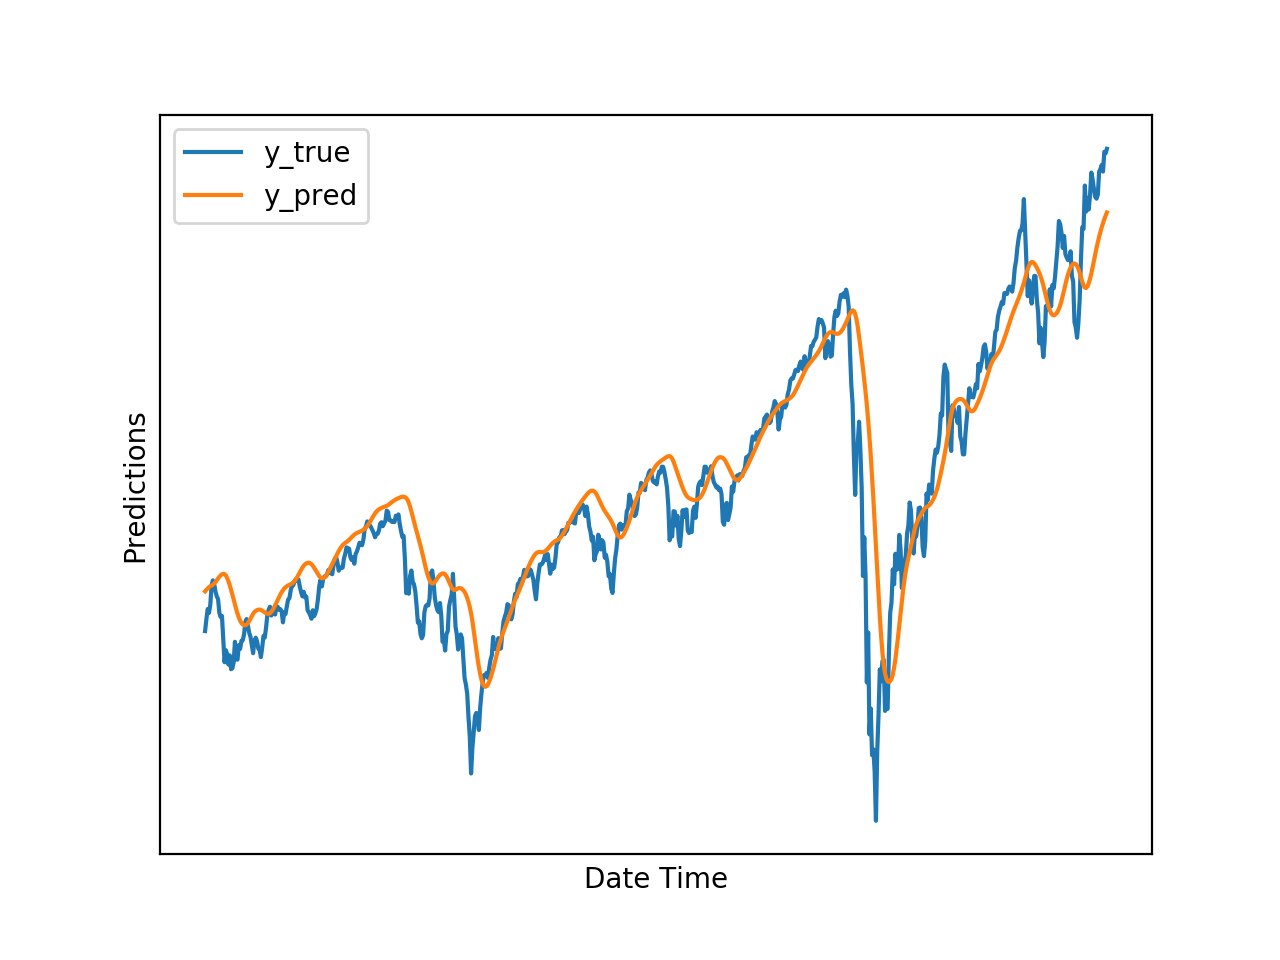

In [121]:
%matplotlib notebook
plt.plot(range(0,696), y_true, label = 'y_true')
plt.plot(range(0,696), y_pred, label = 'y_pred')
plt.xlabel('Date Time')
plt.xticks([])
plt.yticks([])

plt.ylabel('Predictions')
plt.legend()
plt.show()

In [118]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

<IPython.core.display.Javascript object>


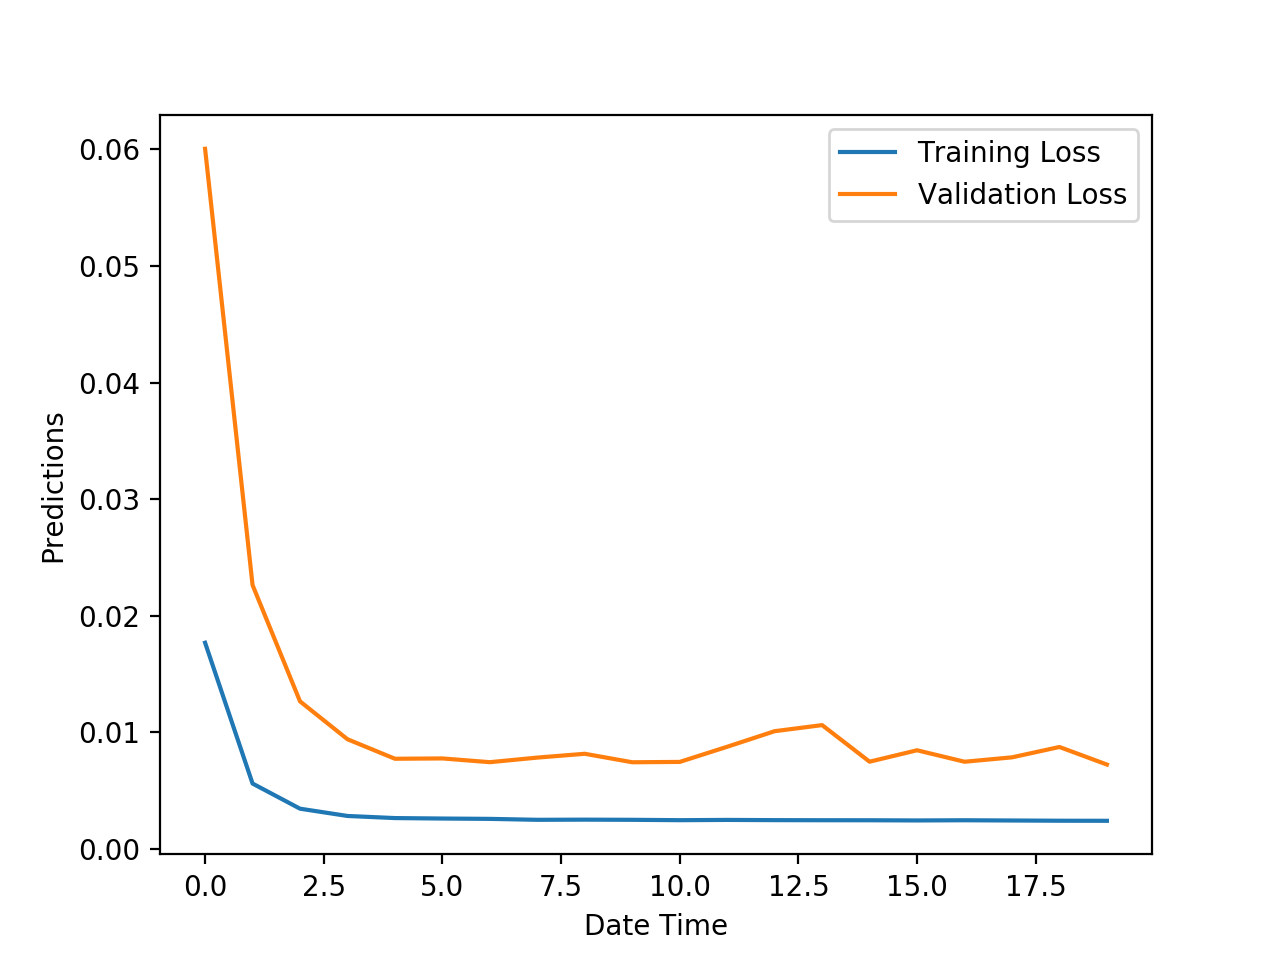

In [119]:
%matplotlib notebook
plt.plot(range(0,len(history.history['loss'])), history.history['loss'], label = 'Training Loss')
plt.plot(range(0,len(history.history['loss'])), history.history['val_loss'] , label = 'Validation Loss')
plt.xlabel('Date Time')
plt.ylabel('Predictions')
plt.legend()
plt.show()